<a href="https://colab.research.google.com/github/saktiworkstation/road-to-ai-developer/blob/main/22_11_4677_Sakti_Linear_Regressii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAKTI KUSUMA AJI | 22.11.4677

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

In [2]:
# Buat Spark session
spark = SparkSession.builder.appName("Linear Regression Studi Kasus").getOrCreate()

In [4]:
# Load dataset dalam format libsvm
data = spark.read.format("libsvm").load("/content/sample_dataset_lr.txt")

# Eksplorasi Data

In [5]:
# Tampilkan 5 baris pertama dataset
data.show(5)

+-------------------+--------------------+
|              label|            features|
+-------------------+--------------------+
| -9.490009878824548|(10,[0,1,2,3,4,5,...|
| 0.2577820163584905|(10,[0,1,2,3,4,5,...|
| -4.438869807456516|(10,[0,1,2,3,4,5,...|
|-19.782762789614537|(10,[0,1,2,3,4,5,...|
| -7.966593841555266|(10,[0,1,2,3,4,5,...|
+-------------------+--------------------+
only showing top 5 rows



# Membangun Model Regresi Linier

In [7]:
# Menggunakan VectorAssembler untuk menggabungkan fitur ke dalam satu kolom
assembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")
data = assembler.transform(data)

In [8]:
# Membagi dataset menjadi 80% data pelatihan dan 20% data pengujian
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [9]:
# Membuat model regresi linier dengan parameter yang ditentukan
lr = LinearRegression(featuresCol="features_vec", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [10]:
# Melatih model pada data pelatihan
lr_model = lr.fit(train_data)

# Evaluasi Model

In [11]:
# Menggunakan model untuk memprediksi nilai pada data pelatihan dan pengujian
train_predictions = lr_model.transform(train_data)
test_predictions = lr_model.transform(test_data)

In [12]:
# Evaluator untuk menghitung RMSE dan R2
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
rmse_test = evaluator.evaluate(test_predictions)

In [13]:
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2_train = r2_evaluator.evaluate(train_predictions)
r2_test = r2_evaluator.evaluate(test_predictions)

In [14]:
print(f"RMSE pada data pelatihan: {rmse_train}")
print(f"R2 pada data pelatihan: {r2_train}")
print(f"RMSE pada data pengujian: {rmse_test}")
print(f"R2 pada data pengujian: {r2_test}")

RMSE pada data pelatihan: 9.876858903901951
R2 pada data pelatihan: 0.04937778051891839
RMSE pada data pengujian: 11.7595272211461
R2 pada data pengujian: -0.09263952849152424


In [15]:
# Menampilkan koefisien dan intercept dari model
print(f"Koefisien: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Koefisien: [0.0,1.029957513871163,-1.1840505799268486,2.2534408792539327,0.44752109430925296,1.354219890929489,0.0,-0.4239968612960364,0.0,0.7338404859230598]
Intercept: 0.2638047645380358


# Visualisasi

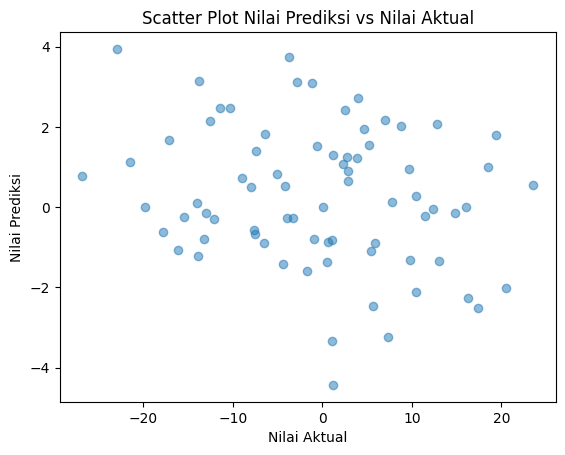

In [16]:
# Membuat scatter plot untuk membandingkan nilai prediksi dengan nilai aktual pada data pengujian
predicted_vs_actual = test_predictions.select("prediction", "label").toPandas()
plt.scatter(predicted_vs_actual["label"], predicted_vs_actual["prediction"], alpha=0.5)
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Scatter Plot Nilai Prediksi vs Nilai Aktual")
plt.show()

# Interpretasi
- Fitur dengan korelasi tertinggi terhadap label akan memberikan pengaruh terbesar pada model.
- Korelasi positif menunjukkan bahwa kenaikan nilai fitur akan meningkatkan nilai target, dan korelasi negatif menunjukkan sebaliknya.
- Model ini mungkin cocok untuk dataset ini jika nilai R2 cukup tinggi, yang menunjukkan bahwa model dapat menjelaskan variasi dalam data.

# Try Imprvement

In [21]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf

In [25]:
# Standardisasi fitur
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

In [32]:
# Membagi dataset menjadi data pelatihan dan pengujian
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [33]:
# Model Gradient Boosted Tree
gbt = GBTRegressor(featuresCol="scaled_features", labelCol="label", maxIter=100, maxDepth=5)
gbt_model = gbt.fit(train_data)

In [34]:
# Evaluasi model
train_predictions = gbt_model.transform(train_data)
test_predictions = gbt_model.transform(test_data)

In [35]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
rmse_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
r2_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})

In [36]:
print(f"RMSE pada data pengujian: {rmse_test}")
print(f"R2 pada data pengujian: {r2_test}")

RMSE pada data pengujian: 12.697752997458402
R2 pada data pengujian: -0.2739457488141426


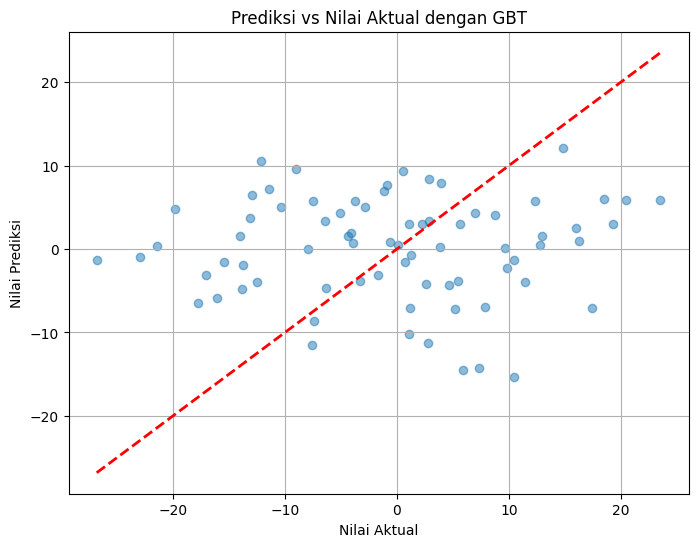

In [37]:
# Visualisasi prediksi vs aktual
predicted_vs_actual = test_predictions.select("prediction", "label").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(predicted_vs_actual["label"], predicted_vs_actual["prediction"], alpha=0.5)
plt.plot([predicted_vs_actual["label"].min(), predicted_vs_actual["label"].max()],
         [predicted_vs_actual["label"].min(), predicted_vs_actual["label"].max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Prediksi vs Nilai Aktual dengan GBT")
plt.grid()
plt.show()